# Self-Stabilizing Gaussian Mixture Models (SGMM)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paradoxysm/dsigm/blob/master/doc/guides/SGMM_1D.ipynb)

The SGMM is a modified Gaussian Mixture Model that integrates an optimization of the ideal number of gaussian components in step with the Expectation Maximization algorithm.

The SGMM works with n-dimensional data. This is a guide on working with 1D data. For an example with multivariate data, see [here](https://colab.research.google.com/github/paradoxysm/dsigm/blob/master/doc/guides/SGMM_2D.ipynb).

In [0]:
!python --version
!git clone https://github.com/paradoxysm/dsigm.git
!git -C /content/dsigm/ pull
import sys
sys.path.append('/content/dsigm')

from dsigm.mixture import SGMM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set()

## A Simple 1D Example

### Creating Some Data

Let's start with creating some example 1-dimensional data to demonstrate the SGMM.

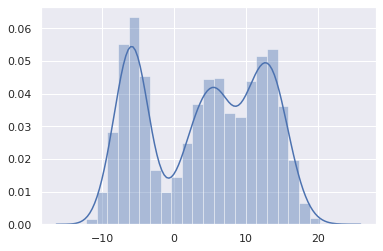

Dataset shape: (10000, 1)


In [0]:
# define the number of samples
n = 10000

# define the mean and variance of the synthetic components
mu = [-6, 5, 13]
sigma = [2, 3, 2.5]

# generate gaussian distributions of samples
X = []
for i in range(n):
    Z = np.random.choice(np.arange(len(mu))) # select the synthetic component
    X.append(np.random.normal(mu[Z], sigma[Z], 1))
X = np.array(X)
sns.distplot(X)
plt.show()
print("Dataset shape:", X.shape)

### Creating Our Model

Now that we have some data, let's create our SGMM model to fit to the data.
All we need to do is make an instance. The parameters have all been included in our call here, but we're just using the default parameter values.

For more information on these parameters, read [here](https://github.com/paradoxysm/dsigm/blob/master/doc/pydoc/SGMM.md).

In [0]:
sgmm = SGMM(init_cores=5, init='kmeans', stabilize=0.5, n_stabilize=5, n_init=10, max_iter=200,
                    tol=1e-3, reg_covar=1e-6, random_state=None)

What we've just done is create an SGMM that will start with 5 "Cores." In dsigm, Cores are really just components of the distribution mixture. They are an instance of some distribution, in this implementation, a Gaussian distribution. But dsigm actually allows you to extend the Core to implement different distributions. For more information, read about Cores [here](https://github.com/paradoxysm/dsigm/blob/master/doc/pydoc/Core.md).

In addition, our stabilize is enabled by default. You can set it `None` if you are looking for a GMM that doesn't stabilize! This results in a normal GMM.

### Fitting Our Model

To fit our model to the data, we only need to make a single call.

In [0]:
sgmm.fit(X)

### Visualizing the Result

Let's examine how well the model has fit the data.

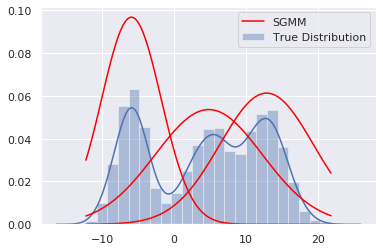

In [0]:
# plot the results
bins = np.linspace(np.min(X),np.max(X),100)
sns.distplot(X, label="True Distribution")

for i in range(len(sgmm.cores)):
    c = sgmm.cores[i]
    plt.plot(bins, norm.pdf(bins, loc=c.mu, scale=c.sigma)[0], color='red')
plt.plot(0, 0, color='red', label="SGMM")

plt.legend(loc='upper right')
plt.show()

You can see how the model has adjusted to the optimal number of components and fits the distribution mixture nicely!

### Predicting New Data

Working with assumption that the data we just provided our model generally represents the real world, we can feed our model new data and determine which of the components it is likely to belong to. This is simply done by finding under which Core (or Gaussian component) the new sample has the highest probability.

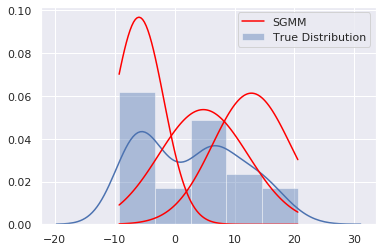

In [0]:
# define the number of samples
n = 100

# generate some data that fit the distribution
Y = []
for i in range(n):
    Z = np.random.choice(np.arange(len(mu))) # select the synthetic component
    Y.append(np.random.normal(mu[Z], sigma[Z], 1))
Y = np.array(Y)

sgmm.predict(Y)

# plot the results
bins = np.linspace(np.min(Y),np.max(Y),100)
sns.distplot(Y, label="True Distribution")

for i in range(len(sgmm.cores)):
    c = sgmm.cores[i]
    plt.plot(bins, norm.pdf(bins, loc=c.mu, scale=c.sigma)[0], color='red')
plt.plot(0, 0, color='red', label="SGMM")

plt.legend(loc='upper right')
plt.show()

And some slightly modified data...

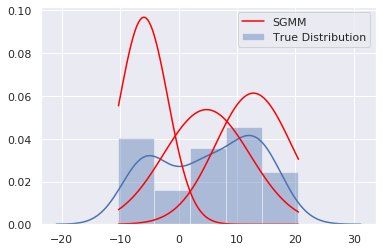

In [0]:
# define the number of samples
n = 100

# generate some data that deviate partially from the distribution
Y_off = []
for i in range(n):
    Z = np.random.choice(np.arange(len(mu))) # select the synthetic component
    mu_modify = np.random.choice([-0.5,0.5]) * np.random.random() + mu[Z]
    sigma_modify = np.random.choice([-0.5,0.5]) * np.random.random() + sigma[Z]
    Y_off.append(np.random.normal(mu_modify, sigma_modify, 1))
Y_off = np.array(Y_off)

sgmm.predict(Y_off)

# plot the results
bins = np.linspace(np.min(Y_off),np.max(Y_off),100)
sns.distplot(Y_off, label="True Distribution")

for i in range(len(sgmm.cores)):
    c = sgmm.cores[i]
    plt.plot(bins, norm.pdf(bins, loc=c.mu, scale=c.sigma)[0], color='red')
plt.plot(0, 0, color='red', label="SGMM")

plt.legend(loc='upper right')
plt.show()

## A Non-Stabilizing Model

SGMM also allows for non-stabilizing models, essentially becoming a normal Gaussian Mixture Model.

Let's create one such model with 3 Cores and fit it to our original training data.

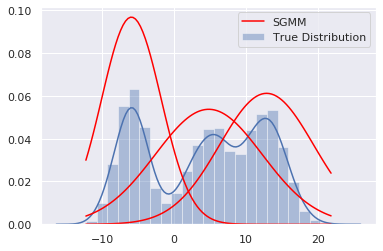

In [0]:
sgmm_fixed = SGMM(init_cores=3, stabilize=None)
sgmm_fixed.fit(X)

# plot the results
bins = np.linspace(np.min(X),np.max(X),100)
sns.distplot(X, label="True Distribution")

for i in range(len(sgmm_fixed.cores)):
    c = sgmm_fixed.cores[i]
    plt.plot(bins, norm.pdf(bins, loc=c.mu, scale=c.sigma)[0], color='red')
plt.plot(0, 0, color='red', label="SGMM")

plt.legend(loc='upper right')
plt.show()

We can compare our model with a GaussianMixture from sklearn.

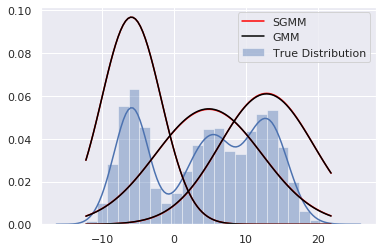

In [0]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
gmm.fit(X)

# plot the results
bins = np.linspace(np.min(X),np.max(X),100)
sns.distplot(X, label="True Distribution")

# sgmm model
for i in range(len(sgmm_fixed.cores)):
    c = sgmm_fixed.cores[i]
    plt.plot(bins, norm.pdf(bins, loc=c.mu, scale=c.sigma)[0], color='red')
plt.plot(0, 0, color='red', label="SGMM")

# gmm model
for i in range(len(gmm.means_)):
    mu = gmm.means_[i]
    sigma = gmm.covariances_[i][0]
    plt.plot(bins, norm.pdf(bins, loc=mu, scale=sigma), color='black')
plt.plot(0, 0, color='black', label="GMM")

plt.legend(loc='upper right')
plt.show()